# 加载数据集

In [1]:
# 加载数据集
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# 加载MNIST数据集并应用转换
transform = transforms.Compose([
    transforms.ToTensor(),  # 将PIL图像转换为PyTorch张量
    transforms.Normalize((0.5,), (0.5,))  # 将像素值归一化到范围[-1, 1]
])

# 加载训练和验证数据集
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# 创建用于训练和验证的数据加载器
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

E:\anaconda3\envs\pykan\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 定义MLP模型

In [11]:
# 定义MLP模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)  # 全连接层，输入特征为28*28，输出特征为64
        self.fc2 = nn.Linear(64, 10)  # 全连接层，输入特征为64，输出特征为10（用于10分类任务）

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 将输入张量展平为一维张量
        x = torch.relu(self.fc1(x))  # 对第一个全连接层的输出应用ReLU激活函数
        x = self.fc2(x)  # 应用第二个全连接层
        return x


# 创建MLP模型实例
model = MLP()

# 将模型移到可用设备（GPU或CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 使用AdamW优化器，学习率为1e-3，权重衰减为1e-4
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 使用指数衰减的学习率调度器，衰减因子（gamma）为0.8
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# 定义交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 打印模型参数数量
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 50890


# 训练模型

In [12]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import time  # 引入 time 模块

# 假设你已经定义了 model, trainloader, valloader, optimizer, criterion, scheduler, device

# 用于记录训练和验证的损失和准确率
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []  # 用于记录每个 epoch 的训练时间

for epoch in range(10):
    start_time = time.time()  # 记录当前epoch的开始时间
    # 将模型设置为训练模式
    model.train()
    
    train_loss = 0
    train_accuracy = 0

    # 使用 tqdm 显示训练进度
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)  # 将图像移到指定设备
            labels = labels.to(device)  # 将标签移到指定设备

            optimizer.zero_grad()  # 梯度清零
            output = model(images)  # 前向传播
            loss = criterion(output, labels)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数

            train_loss += loss.item()
            train_accuracy += (output.argmax(dim=1) == labels).float().mean().item()

            pbar.set_postfix(loss=loss.item(), accuracy=(output.argmax(dim=1) == labels).float().mean().item(), lr=optimizer.param_groups[0]['lr'])

    train_loss /= len(trainloader)
    train_accuracy /= len(trainloader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 验证
    model.eval()  # 将模型设置为评估模式
    val_loss = 0
    val_accuracy = 0

    with torch.no_grad():
        # 遍历验证数据集
        for images, labels in valloader:
            images = images.to(device)  # 将图像移到指定设备
            labels = labels.to(device)  # 将标签移到指定设备

            output = model(images)  # 前向传播
            val_loss += criterion(output, labels).item()  # 累积验证损失
            val_accuracy += ((output.argmax(dim=1) == labels).float().mean().item())  # 累积验证准确率

    val_loss /= len(valloader)  # 计算平均验证损失
    val_accuracy /= len(valloader)  # 计算平均验证准确率

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()  # 更新学习率
    
    end_time = time.time()  # 记录当前epoch的结束时间
    epoch_time = end_time - start_time  # 计算当前epoch的持续时间
    epoch_times.append(epoch_time)  # 记录持续时间

    # 打印当前 epoch 的验证损失和准确率
    print(f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")



100%|██████████| 938/938 [00:10<00:00, 92.19it/s, accuracy=0.969, loss=0.129, lr=0.001] 


Epoch 1, Val Loss: 0.25720189084079426, Val Accuracy: 0.9246616242038217


100%|██████████| 938/938 [00:10<00:00, 85.69it/s, accuracy=0.875, loss=0.372, lr=0.0008] 


Epoch 2, Val Loss: 0.20837273247611182, Val Accuracy: 0.9370023885350318


100%|██████████| 938/938 [00:10<00:00, 86.74it/s, accuracy=0.938, loss=0.175, lr=0.00064]  


Epoch 3, Val Loss: 0.15437719245162454, Val Accuracy: 0.9536226114649682


100%|██████████| 938/938 [00:11<00:00, 85.27it/s, accuracy=0.875, loss=0.296, lr=0.000512]  


Epoch 4, Val Loss: 0.13500675769926163, Val Accuracy: 0.9592953821656051


100%|██████████| 938/938 [00:10<00:00, 88.86it/s, accuracy=0.969, loss=0.0721, lr=0.00041]


Epoch 5, Val Loss: 0.13608006306829015, Val Accuracy: 0.9599920382165605


100%|██████████| 938/938 [00:11<00:00, 83.95it/s, accuracy=0.969, loss=0.0684, lr=0.000328]


Epoch 6, Val Loss: 0.11755835638488317, Val Accuracy: 0.9643710191082803


100%|██████████| 938/938 [00:11<00:00, 80.74it/s, accuracy=0.938, loss=0.133, lr=0.000262] 


Epoch 7, Val Loss: 0.11819431383554248, Val Accuracy: 0.9643710191082803


100%|██████████| 938/938 [00:11<00:00, 83.55it/s, accuracy=0.906, loss=0.226, lr=0.00021] 


Epoch 8, Val Loss: 0.1098853460102265, Val Accuracy: 0.9672571656050956


100%|██████████| 938/938 [00:11<00:00, 84.21it/s, accuracy=0.938, loss=0.203, lr=0.000168] 


Epoch 9, Val Loss: 0.11120967786450675, Val Accuracy: 0.9670581210191083


100%|██████████| 938/938 [00:10<00:00, 85.88it/s, accuracy=1, loss=0.0702, lr=0.000134]    


Epoch 10, Val Loss: 0.1051043420763105, Val Accuracy: 0.9680533439490446


# 绘制损失函数图

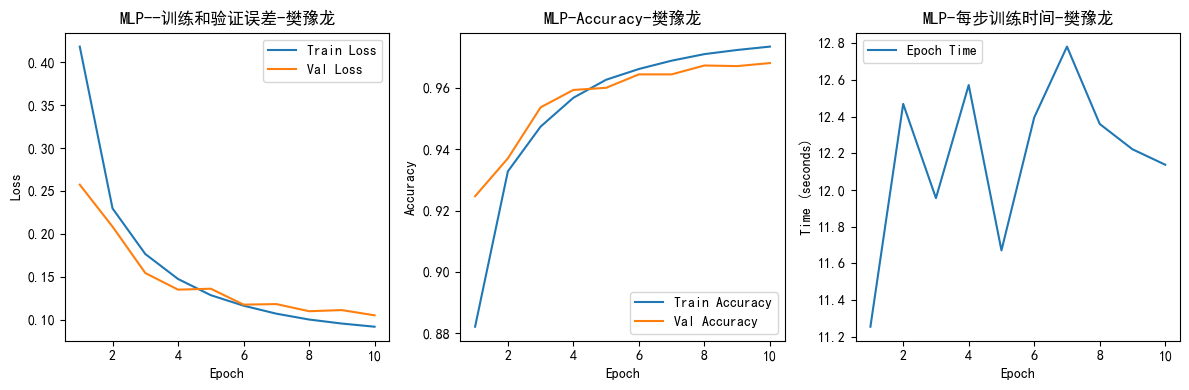

In [16]:
# 绘制损失函数图
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP--训练和验证误差-樊豫龙')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP-Accuracy-樊豫龙')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, 11), epoch_times, label='Epoch Time')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('MLP-每步训练时间-樊豫龙')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
torch.save(model.state_dict(), "./models/mlp.pth")